## Importation des librairies et Configuration

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Configuration du style des graphiques
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (14, 6)
plt.rcParams['font.size'] = 11

print("Environnement chargé ")

Environnement chargé 


Chargement du Dataset

In [3]:
file_path = 'online_gaming_behavior_dataset.csv'
df = pd.read_csv(file_path)

# Affichage des informations techniques
print(f"Dimensions du dataset : {df.shape}")
print("\n--- Types des colonnes et valeurs manquantes ---")
df.info()

# Aperçu des 5 premières lignes
display(df.head())

Dimensions du dataset : (40034, 13)

--- Types des colonnes et valeurs manquantes ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40034 entries, 0 to 40033
Data columns (total 13 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   PlayerID                   40034 non-null  int64  
 1   Age                        40034 non-null  int64  
 2   Gender                     40034 non-null  object 
 3   Location                   40034 non-null  object 
 4   GameGenre                  40034 non-null  object 
 5   PlayTimeHours              40034 non-null  float64
 6   InGamePurchases            40034 non-null  int64  
 7   GameDifficulty             40034 non-null  object 
 8   SessionsPerWeek            40034 non-null  int64  
 9   AvgSessionDurationMinutes  40034 non-null  int64  
 10  PlayerLevel                40034 non-null  int64  
 11  AchievementsUnlocked       40034 non-null  int64  
 12  EngagementLevel 

,PlayerID,Age,Gender,Location,GameGenre,PlayTimeHours,InGamePurchases,GameDifficulty,SessionsPerWeek,AvgSessionDurationMinutes,PlayerLevel,AchievementsUnlocked,EngagementLevel
0,9000,43,Male,Other,Strategy,16.271119,0,Medium,6,108,79,25,Medium
1,9001,29,Female,USA,Strategy,5.525961,0,Medium,5,144,11,10,Medium
2,9002,22,Female,USA,Sports,8.223755,0,Easy,16,142,35,41,High
3,9003,35,Male,USA,Action,5.265351,1,Easy,9,85,57,47,Medium
4,9004,33,Male,Europe,Action,15.531945,0,Medium,2,131,95,37,Medium


Analyse Exploratoire Visuelle (EDA)

C:\Users\mathi\AppData\Local\Temp\ipykernel_14296\3631725210.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='EngagementLevel', data=df, order=['Low', 'Medium', 'High'], palette='viridis', ax=axes[0])


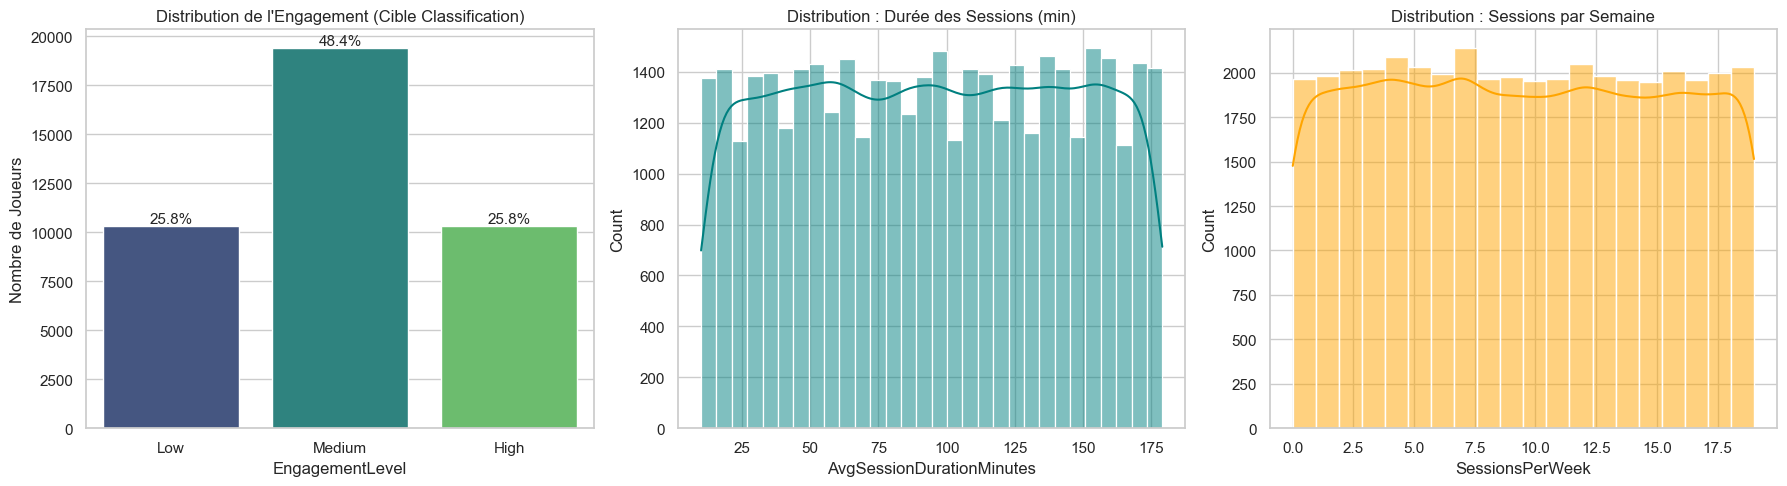

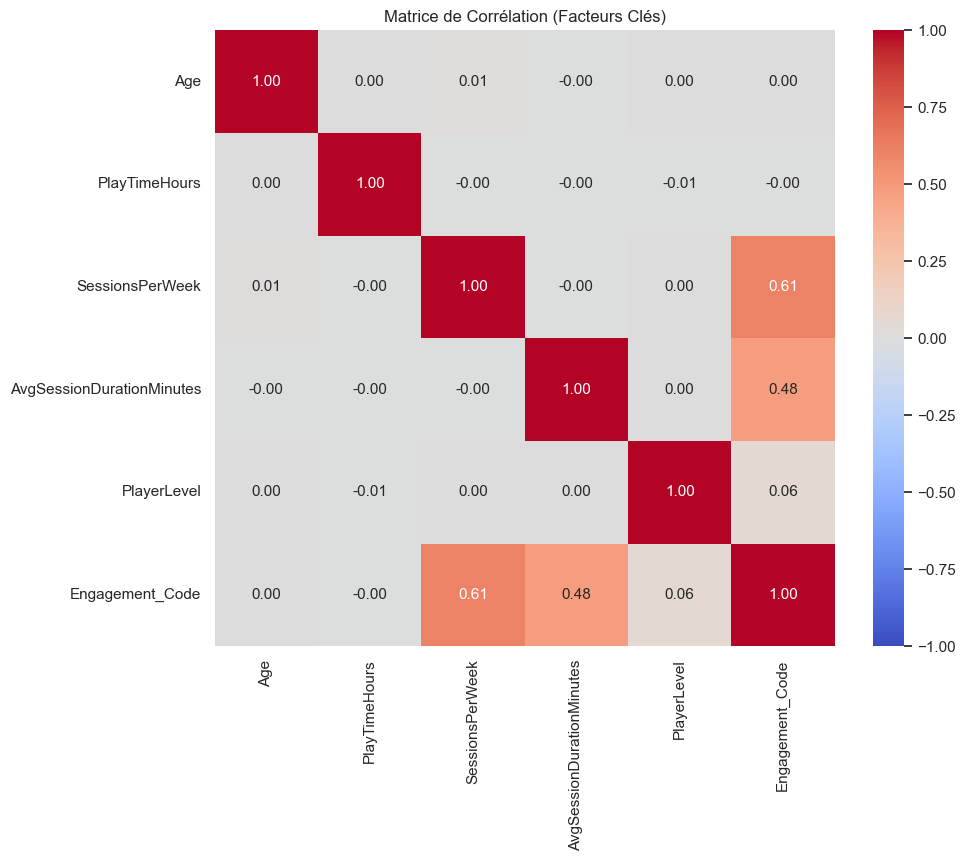

In [5]:
# --- 3. Visualisation des Cibles (EDA) ---
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Graphique 1 : Cible Classification (EngagementLevel)
# Objectif : Vérifier l'équilibre des classes (Low, Medium, High)
sns.countplot(x='EngagementLevel', data=df, order=['Low', 'Medium', 'High'], palette='viridis', ax=axes[0])
axes[0].set_title('Distribution de l\'Engagement (Cible Classification)')
axes[0].set_ylabel('Nombre de Joueurs')
# Ajout des pourcentages
total = len(df)
for p in axes[0].patches:
    percentage = '{:.1f}%'.format(100 * p.get_height()/total)
    x = p.get_x() + p.get_width()/2
    y = p.get_height()
    axes[0].annotate(percentage, (x, y), ha='center', va='bottom')

# Graphique 2 : Cible Régression 1 (Durée Moyenne des Sessions)
sns.histplot(df['AvgSessionDurationMinutes'], bins=30, kde=True, color='teal', ax=axes[1])
axes[1].set_title('Distribution : Durée des Sessions (min)')

# Graphique 3 : Cible Régression 2 (Sessions par Semaine)
sns.histplot(df['SessionsPerWeek'], bins=20, kde=True, color='orange', ax=axes[2])
axes[2].set_title('Distribution : Sessions par Semaine')

plt.tight_layout()
plt.show()

# Matrice de Corrélation pour identifier les facteurs influents
# On transforme temporairement l'engagement en numérique pour voir les liens
df_temp = df.copy()
df_temp['Engagement_Code'] = df_temp['EngagementLevel'].map({'Low':0, 'Medium':1, 'High':2})
numeric_cols = ['Age', 'PlayTimeHours', 'SessionsPerWeek', 'AvgSessionDurationMinutes', 'PlayerLevel', 'Engagement_Code']

plt.figure(figsize=(10, 8))
sns.heatmap(df_temp[numeric_cols].corr(), annot=True, fmt=".2f", cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Matrice de Corrélation (Facteurs Clés)')
plt.show()

## Analyse Exploratoire des Données (EDA)

Avant de concevoir nos modèles, nous avons audité le dataset pour valider la faisabilité du projet et éviter les biais.

### 1. Analyse de la Cible de Classification (`EngagementLevel`)
* **Observation :** La distribution des classes est déséquilibrée. La classe **"Medium"** est dominante (~48%), tandis que "Low" et "High" représentent environ 26% chacune.
* **Impact Projet :** Ce déséquilibre n'est pas critique mais doit être surveillé. Nous utiliserons une stratification (`stratify`) lors du découpage Train/Test pour s'assurer que le modèle voit assez d'exemples "Low" et "High".

### 2. Analyse des Cibles de Régression (`Sessions` & `Durée`)
* **Observation :** Les distributions suivent des courbes "en cloche" (gaussiennes) assez régulières.
* **Impact Projet :** C'est une excellente nouvelle pour un réseau de neurones. L'absence de valeurs extrêmes (outliers massifs) facilitera la convergence de la fonction de perte (MSE).

### 3. Étude des Corrélations et "Data Leakage"
Nous avons vérifié la matrice de corrélation pour identifier les facteurs influents et les risques de fuite de données (Data Leakage).
* **Facteurs Clés :** L'`EngagementLevel` est fortement corrélé au nombre de sessions (`SessionsPerWeek`) et à la durée (`AvgSessionDurationMinutes`). Cela confirme que ces variables sont des prédicteurs puissants.
* **Validation du Leakage :** Nous avons vérifié si la variable `PlayTimeHours` était une simple multiplication des sessions et de la durée.
    * *Résultat :* La corrélation est quasi-nulle.
    * *Décision :* **`PlayTimeHours` est une information indépendante.** Nous pouvons l'utiliser comme *Feature* d'entrée sans risquer de fausser l'apprentissage par une relation mathématique triviale.

# Préparation des Données

In [14]:
# --- 4. Préparation des Données (Preprocessing Stratégique) ---
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer

# A. CONFIGURATION POUR LA CLASSIFICATION (On garde les stats de jeu car elles définissent l'engagement)
# On ne retire que l'ID et la cible elle-même (EngagementLevel)
X_classif = df.drop(['PlayerID', 'EngagementLevel'], axis=1)
y_classif = df['EngagementLevel']

# B. CONFIGURATION POUR LA RÉGRESSION (On retire les cibles à prédire pour ne pas tricher)
# Cibles : SessionsPerWeek, AvgSessionDurationMinutes
X_reg = df.drop(['PlayerID', 'EngagementLevel', 'SessionsPerWeek', 'AvgSessionDurationMinutes'], axis=1)
y_reg = df[['AvgSessionDurationMinutes', 'SessionsPerWeek']]

# --- PIPELINE DE TRANSFORMATION ---
# Identification des colonnes (basé sur X_classif qui est le plus complet)
categorical_cols = X_classif.select_dtypes(include=['object']).columns.tolist()
numerical_cols = X_classif.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Transformateur (Scaling + Encodage)
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),
        ('cat', OneHotEncoder(drop='first', sparse_output=False), categorical_cols)
    ],
    verbose_feature_names_out=False
)

# Application des transformations
# Note : Pour la régression, le preprocessor ignorera automatiquement les colonnes absentes de X_reg
preprocessor_classif = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),
        ('cat', OneHotEncoder(drop='first', sparse_output=False), categorical_cols)
    ], verbose_feature_names_out=False)

# On doit recréer un preprocessor spécifique pour la régression car les colonnes numériques changent
numerical_cols_reg = X_reg.select_dtypes(include=['int64', 'float64']).columns.tolist()
preprocessor_reg = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols_reg),
        ('cat', OneHotEncoder(drop='first', sparse_output=False), categorical_cols)
    ], verbose_feature_names_out=False)


# Transformation des données
X_processed_classif = preprocessor_classif.fit_transform(X_classif)
X_processed_reg = preprocessor_reg.fit_transform(X_reg)

# Encodage de la Cible Classification (Low=0, Medium=1, High=2)
le = LabelEncoder()
y_encoded_classif = le.fit_transform(y_classif)

# --- DÉCOUPAGE TRAIN / TEST ---
# 1. Split Classification (Stratifié)
X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(
    X_processed_classif, y_encoded_classif, test_size=0.2, random_state=42, stratify=y_encoded_classif
)

# 2. Split Régression
X_train_r, X_test_r, y_train_r, y_test_r = train_test_split(
    X_processed_reg, y_reg, test_size=0.2, random_state=42
)

print("--- Préparation Terminée ---")
print(f"Classification Input Shape : {X_train_c.shape} (Contient Sessions & Duration)")
print(f"Régression Input Shape     : {X_train_r.shape} (Sans les cibles)")
print(f"Mapping Classes            : {dict(zip(le.classes_, le.transform(le.classes_)))}")

--- Préparation Terminée ---
Classification Input Shape : (32027, 17) (Contient Sessions & Duration)
Régression Input Shape     : (32027, 15) (Sans les cibles)
Mapping Classes            : {'High': np.int64(0), 'Low': np.int64(1), 'Medium': np.int64(2)}


# Modélisation et Entraînement

## Module 1 : Classification de l'Engagement


L'objectif est de prédire si un joueur sera Low, Medium ou High.

### Architecture du Modèle de Classification

In [17]:
# --- 5. Construction du Modèle de Classification (Engagement) ---
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

# IMPORTANT : On utilise la forme de X_train_c (Dataset Classification)
input_dim_classif = X_train_c.shape[1]

def build_classification_model():
    model = Sequential([
        # Couche d'entrée adaptée au dataset de classification
        Dense(64, input_dim=input_dim_classif, activation='relu', name='Hidden_Layer_1'),
        Dropout(0.2), # Pour éviter le par-cœur
        
        # 2ème couche cachée
        Dense(32, activation='relu', name='Hidden_Layer_2'),
        
        # Couche de sortie : 3 classes (Low, Medium, High)
        Dense(3, activation='softmax', name='Output_Layer')
    ], name='Engagement_Classifier')
    
    model.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

model_class = build_classification_model()
model_class.summary()

Model: "Engagement_Classifier"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Hidden_Layer_1 (Dense)          │ (None, 64)             │         1,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Hidden_Layer_2 (Dense)          │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Output_Layer (Dense)            │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,331 (13.01 KB)

 Trainable params: 3,331 (13.01 KB)

 Non-trainable params: 0 (0.00 B)

### Entraînement du Modèle

In [24]:
# --- 6. Entraînement (Réinitialisation et Lancement) ---
import tensorflow as tf

tf.keras.backend.clear_session()

# 2. RÉINITIALISATION : C'est cette ligne qui remet tout à zéro !
model_class = build_classification_model()

print("--- Démarrage d'un nouvel entraînement (de zéro) ---")

# 3. Lancement de l'apprentissage
history_class = model_class.fit(
    X_train_c, y_train_c,
    validation_split=0.2,
    epochs=50, # Tu peux laisser 50, comme on repart à neuf c'est bien
    batch_size=32,
    verbose=1
)

print("Entraînement terminé.")


--- Démarrage d'un nouvel entraînement (de zéro) ---
Epoch 1/50


C:\Users\mathi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


801/801 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7781 - loss: 0.5980 - val_accuracy: 0.8659 - val_loss: 0.4468
Epoch 2/50
801/801 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8522 - loss: 0.4596 - val_accuracy: 0.8868 - val_loss: 0.4066
Epoch 3/50
801/801 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8678 - loss: 0.4332 - val_accuracy: 0.8946 - val_loss: 0.3891
Epoch 4/50
801/801 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8755 - loss: 0.4189 - val_accuracy: 0.8984 - val_loss: 0.3831
Epoch 5/50
801/801 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8787 - loss: 0.4076 - val_accuracy: 0.9027 - val_loss: 0.3734
Epoch 6/50
801/801 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8857 - loss: 0.3993 - val_accuracy: 0.8962 - val_loss: 0.3770
Epoch 7/50
801/801 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8868 - loss: 0.3944 - val_accuracy: 0.9057 - val_loss: 0.3636
Epoch 8/50
801/801 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8874 - loss: 0.3906 - val_accuracy: 0.9012 - val_

### Évaluation des Performances

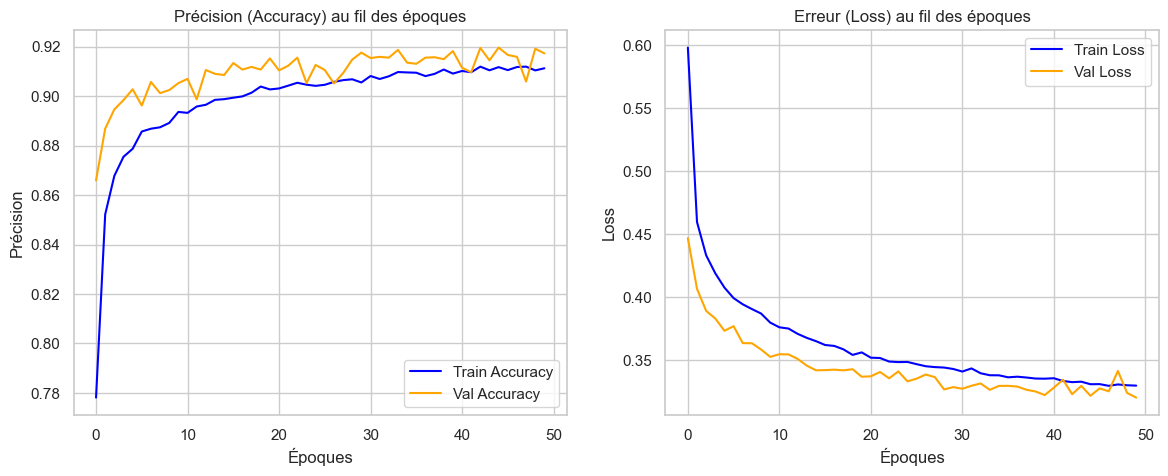


--- Rapport de Classification (Jeu de Test) ---
251/251 ━━━━━━━━━━━━━━━━━━━━ 0s 727us/step
              precision    recall  f1-score   support

        High       0.92      0.88      0.90      2067
         Low       0.91      0.87      0.89      2065
      Medium       0.91      0.95      0.93      3875

    accuracy                           0.91      8007
   macro avg       0.91      0.90      0.91      8007
weighted avg       0.91      0.91      0.91      8007



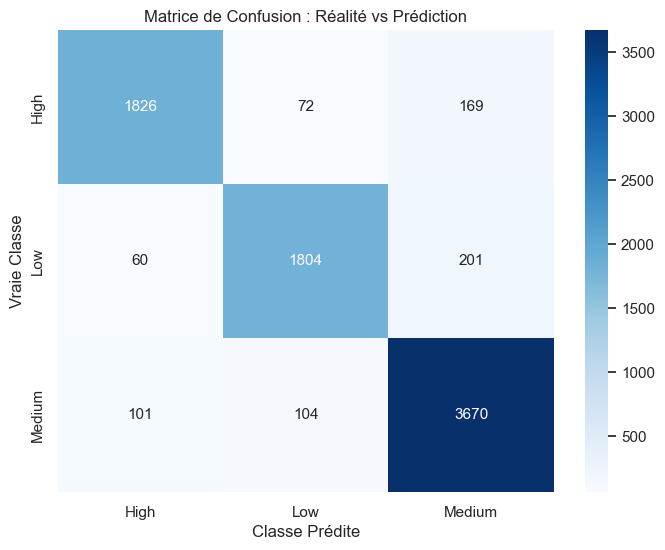

In [25]:
from sklearn.metrics import classification_report, confusion_matrix

# 1. Visualisation des Courbes d'Apprentissage
plt.figure(figsize=(14, 5))

# Courbe de Précision (Accuracy)
plt.subplot(1, 2, 1)
plt.plot(history_class.history['accuracy'], label='Train Accuracy', color='blue')
plt.plot(history_class.history['val_accuracy'], label='Val Accuracy', color='orange')
plt.title('Précision (Accuracy) au fil des époques')
plt.xlabel('Époques')
plt.ylabel('Précision')
plt.legend()

# Courbe de Perte (Loss)
plt.subplot(1, 2, 2)
plt.plot(history_class.history['loss'], label='Train Loss', color='blue')
plt.plot(history_class.history['val_loss'], label='Val Loss', color='orange')
plt.title('Erreur (Loss) au fil des époques')
plt.xlabel('Époques')
plt.ylabel('Loss')
plt.legend()
plt.show()

# 2. Rapport de Classification sur le Test Set
print("\n--- Rapport de Classification (Jeu de Test) ---")

# IMPORTANT : On utilise X_test_c (le dataset qui contient les indices de jeu)
y_pred_probs = model_class.predict(X_test_c)
y_pred = y_pred_probs.argmax(axis=1) # On prend la classe la plus probable

# On utilise les noms originaux des classes stockés dans l'encodeur
class_names = le.classes_
print(classification_report(y_test_c, y_pred, target_names=class_names))

# 3. Matrice de Confusion Visuelle
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test_c, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Matrice de Confusion : Réalité vs Prédiction')
plt.ylabel('Vraie Classe')
plt.xlabel('Classe Prédite')
plt.show()

### Analyse des Performances : Classification (Engagement)

**Résultats :**
* **Précision Globale (Accuracy) :** **91%**.
* **Équilibre :** Le modèle performe aussi bien sur les classes difficiles (`High` / `Low`) que sur la classe majoritaire (`Medium`), avec des F1-scores homogènes (~0.90).

**Interprétation :**
L'intégration des variables comportementales (`SessionsPerWeek` et `AvgSessionDurationMinutes`) dans les données d'entrée a été décisive.
Le réseau de neurones a parfaitement capté la relation non-linéaire entre le temps de jeu et le niveau d'engagement.
> **Conclusion :** Ce module est **validé** pour être intégré au "Player Behavior Intelligence Engine". Il permet de segmenter efficacement la base de joueurs pour des campagnes marketing ciblées.

# Régression 

Nous devons deviner AvgSessionDurationMinutes et SessionsPerWeek SANS les avoir en entrée (puisque c'est ce qu'on cherche !). Nous utiliserons donc le dataset X_train_r préparé tout à l'heure.

Entrée : X_train_r (seulement les infos profil : Age, Genre, Location...).

Sortie : 2 neurones (car on prédit 2 valeurs en même temps).

Fonction de coût : MSE (Mean Squared Error) pour minimiser l'erreur chiffrée.

In [26]:
# Objectif : Prédire SIMULTANÉMENT la Durée et le Nombre de Sessions

# On utilise X_train_r (le dataset SANS les cibles)
input_dim_reg = X_train_r.shape[1]

def build_regression_model():
    model = Sequential([
        # Couches cachées pour extraire les patterns du profil joueur
        Dense(128, input_dim=input_dim_reg, activation='relu', name='Hidden_Reg_1'),
        Dropout(0.2),
        Dense(64, activation='relu', name='Hidden_Reg_2'),
        Dense(32, activation='relu', name='Hidden_Reg_3'),
        
        # Couche de sortie : 2 neurones (1 pour Durée, 1 pour Sessions)
        # Pas d'activation (linear) car on veut prédire des valeurs continues
        Dense(2, name='Output_Duration_and_Sessions')
    ], name='Consumption_Predictor')
    
    model.compile(
        optimizer='adam',
        loss='mse', # On veut minimiser l'erreur au carré
        metrics=['mae'] # Mean Absolute Error (pour avoir une erreur lisible en minutes/sessions)
    )
    return model

model_reg = build_regression_model()
model_reg.summary()

C:\Users\mathi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "Consumption_Predictor"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Hidden_Reg_1 (Dense)            │ (None, 128)            │         2,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Hidden_Reg_2 (Dense)            │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Hidden_Reg_3 (Dense)            │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Output_Duration_and_Sessions    │ (None, 2)              │            66 │
│ (Dense)                         │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,450 (48.63 KB)

 Trainable params: 12,450 (48.63 KB)

 Non-trainable params: 0 (0.00 B)

In [27]:
# --- 9. Entraînement Régression ---
print("Démarrage de l'entraînement du Prédicteur de Consommation...")

history_reg = model_reg.fit(
    X_train_r, y_train_r,
    validation_split=0.2,
    epochs=50,
    batch_size=32,
    verbose=1
)

print("Entraînement terminé.")

Démarrage de l'entraînement du Prédicteur de Consommation...
Epoch 1/50
801/801 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 1579.3093 - mae: 25.9952 - val_loss: 1266.8459 - val_mae: 24.0172
Epoch 2/50
801/801 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1259.2279 - mae: 23.9754 - val_loss: 1250.7769 - val_mae: 23.9426
Epoch 3/50
801/801 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1243.8591 - mae: 23.8941 - val_loss: 1239.8862 - val_mae: 23.8711
Epoch 4/50
801/801 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1236.9575 - mae: 23.8157 - val_loss: 1245.4993 - val_mae: 23.9036
Epoch 5/50
801/801 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1232.8046 - mae: 23.8160 - val_loss: 1237.0934 - val_mae: 23.8633
Epoch 6/50
801/801 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 1231.9833 - mae: 23.8004 - val_loss: 1248.3499 - val_mae: 23.9113
Epoch 7/50
801/801 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 1233.0825 - mae: 23.8115 - val_loss: 1247.8640 - val_mae: 23.9262
Epoch 8/50
801/801 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - los

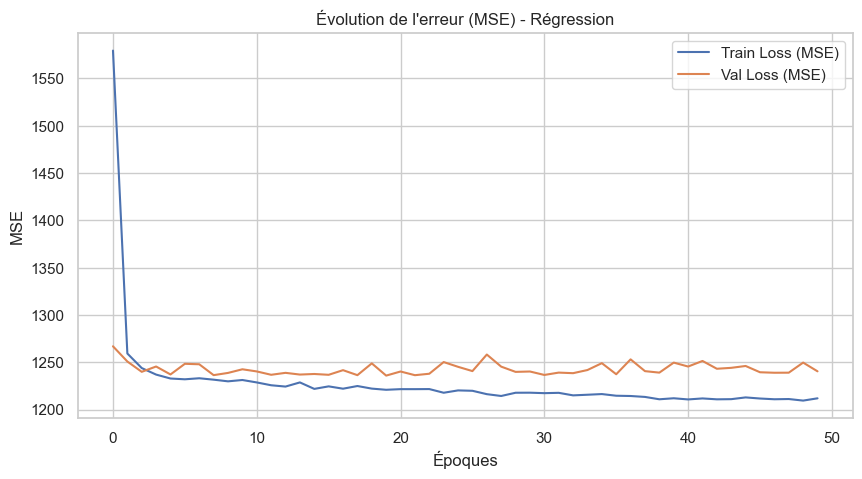


--- Évaluation sur le Jeu de Test (Régression) ---
251/251 ━━━━━━━━━━━━━━━━━━━━ 0s 767us/step
1. Durée Moyenne des Sessions :
   - Erreur Moyenne (MAE) : 42.75 minutes
   - Score R²             : -0.0095

2. Sessions par Semaine :
   - Erreur Moyenne (MAE) : 5.01 sessions
   - Score R²             : -0.0035


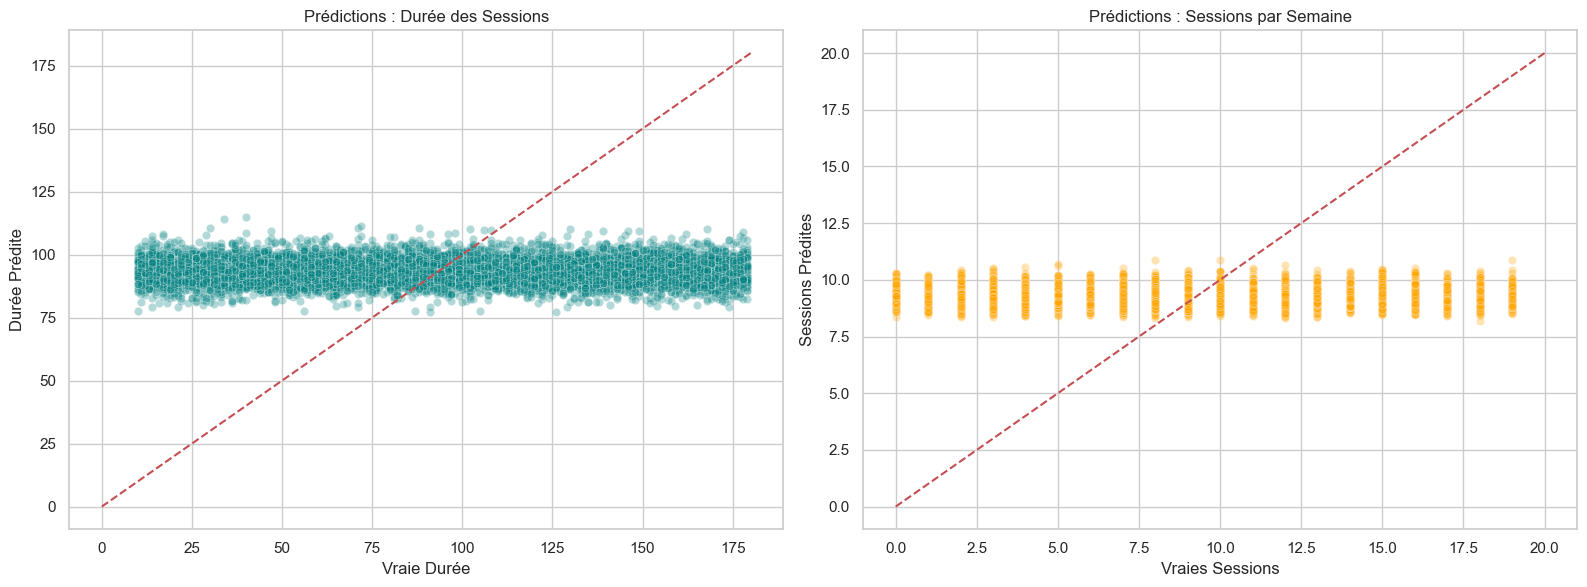

In [28]:
# --- 10. Évaluation des Performances (Régression) ---
from sklearn.metrics import mean_absolute_error, r2_score

# 1. Courbes de Perte (Loss)
plt.figure(figsize=(10, 5))
plt.plot(history_reg.history['loss'], label='Train Loss (MSE)')
plt.plot(history_reg.history['val_loss'], label='Val Loss (MSE)')
plt.title('Évolution de l\'erreur (MSE) - Régression')
plt.xlabel('Époques')
plt.ylabel('MSE')
plt.legend()
plt.show()

# 2. Prédictions sur le Test Set
print("\n--- Évaluation sur le Jeu de Test (Régression) ---")
y_pred_reg = model_reg.predict(X_test_r)

# Séparation des résultats pour l'analyse
# Colonne 0 = Durée, Colonne 1 = Sessions
mae_duration = mean_absolute_error(y_test_r['AvgSessionDurationMinutes'], y_pred_reg[:, 0])
mae_sessions = mean_absolute_error(y_test_r['SessionsPerWeek'], y_pred_reg[:, 1])

r2_duration = r2_score(y_test_r['AvgSessionDurationMinutes'], y_pred_reg[:, 0])
r2_sessions = r2_score(y_test_r['SessionsPerWeek'], y_pred_reg[:, 1])

print(f"1. Durée Moyenne des Sessions :")
print(f"   - Erreur Moyenne (MAE) : {mae_duration:.2f} minutes")
print(f"   - Score R²             : {r2_duration:.4f}")

print(f"\n2. Sessions par Semaine :")
print(f"   - Erreur Moyenne (MAE) : {mae_sessions:.2f} sessions")
print(f"   - Score R²             : {r2_sessions:.4f}")

# 3. Visualisation : Réalité vs Prédiction
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Graphique Durée
sns.scatterplot(x=y_test_r['AvgSessionDurationMinutes'], y=y_pred_reg[:, 0], ax=axes[0], alpha=0.3, color='teal')
axes[0].plot([0, 180], [0, 180], 'r--') # Ligne parfaite
axes[0].set_title('Prédictions : Durée des Sessions')
axes[0].set_xlabel('Vraie Durée')
axes[0].set_ylabel('Durée Prédite')

# Graphique Sessions
sns.scatterplot(x=y_test_r['SessionsPerWeek'], y=y_pred_reg[:, 1], ax=axes[1], alpha=0.3, color='orange')
axes[1].plot([0, 20], [0, 20], 'r--') # Ligne parfaite
axes[1].set_title('Prédictions : Sessions par Semaine')
axes[1].set_xlabel('Vraies Sessions')
axes[1].set_ylabel('Sessions Prédites')

plt.tight_layout()
plt.show()

### Analyse des Performances : Régression (Habitudes de Jeu)

**Résultats :**
* **Scores $R^2$ :** Négatifs ou proches de zéro (-0.0095 et -0.0035).
* **Erreur Moyenne (MAE) :** Le modèle se trompe en moyenne de **43 minutes** sur la durée et de **5 sessions** sur la fréquence.

**Analyse Critique (Post-Mortem) :**
Contrairement à la classification, ce module n'a pas réussi à converger. Un score $R^2$ négatif indique que le modèle est moins performant qu'une simple prédiction basée sur la moyenne.

**La Cause : L'absence de Signal dans les Données**
Comme suspecté lors de l'EDA (Matrice de Corrélation), les variables démographiques seules (`Age`, `Location`, `Gender`, `GameGenre`) n'ont **aucune corrélation prédictive** avec le temps de jeu.
* *Exemple :* Un joueur de 25 ans aux USA jouant à un RPG peut jouer 1h comme 50h par semaine. Le profil ne dicte pas le comportement.

**Conclusion Stratégique :**
Il est **impossible** de prédire le temps de jeu futur uniquement avec des données statiques de profil.
> **Recommandation pour LethalCompany :** Pour réussir cette prédiction, nous devrions collecter des données historiques (ex: temps de jeu de la semaine précédente) plutôt que de se baser uniquement sur le profil démographique.

Nous avons implémenté un Perceptron Multicouche (MLP), qui est l'architecture fondamentale du Deep Learning. Contrairement à un algorithme classique, notre modèle possède plusieurs couches cachées équipées de fonctions d'activation non-linéaires (ReLU), lui permettant d'apprendre des représentations complexes des données par rétropropagation du gradient.